In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/Users/rohanpatel/Desktop/Sports Analytics/Soccer Analytics/Free Kick Analysis/Data/Event Data/manipulatedEventData.csv")

In [5]:
df = df.query("subEventName != 'Free Kick cross'")

In [6]:
df_dropped = df.drop(['Unnamed: 0', 'eventId', 'playerId', 'positions',
              'matchId', 'subEventName','eventName', 'teamId', 'matchPeriod',
              'eventSec', 'subEventId', 'id', 'resultId', 'startX',
              'startY', 'endX', 'endY', 'Tag', 'Label', 'Description',
              'adjustedY', 'passportArea', 'weight', 'firstName', 
              'middleName', 'lastName', 'currentTeamId', 'birthDate',
              'height','role','birthArea','wyId','foot','shortName',
               'currentNationalTeamId'], axis = 1)

Filter Dataset for Freekicks from less than 40 feet

In [7]:
df_clean = df_dropped.query("distGoalX < 38")

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


In [9]:
X = df_clean[['distGoalX', 'distGoalY', 'isLeftFooted']]
y = df_clean['Is_Goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [10]:
smote = SMOTE(sampling_strategy=0.05)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(y_train_smote.value_counts())

0    9692
1     484
Name: Is_Goal, dtype: int64


In [11]:
# Initialize the model
model = LogisticRegression()

# Fit the model
model.fit(X_train_smote, y_train_smote)


LogisticRegression()

In [12]:
probabilities = model.predict_proba(X_test)[:, 1] 

In [13]:
X_test['predictedMake'] = probabilities
X_test['Is_Goal'] = y_test

In [14]:
probabilities_full = model.predict_proba(X)[:, 1]

In [15]:
X['predictedMake'] = probabilities_full
X['Is_Goal'] = y

/var/folders/c0/f1qyzqw120gf28k2qshz4xd40000gn/T/ipykernel_19135/624546851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['predictedMake'] = probabilities_full


In [16]:
full_stats = pd.merge(df, X['predictedMake'],
                      left_index = True,
                      right_index = True)

In [17]:
aggStatsX = pd.DataFrame(full_stats.groupby('distGoalX').agg({'predictedMake' : 'mean'})).reset_index()

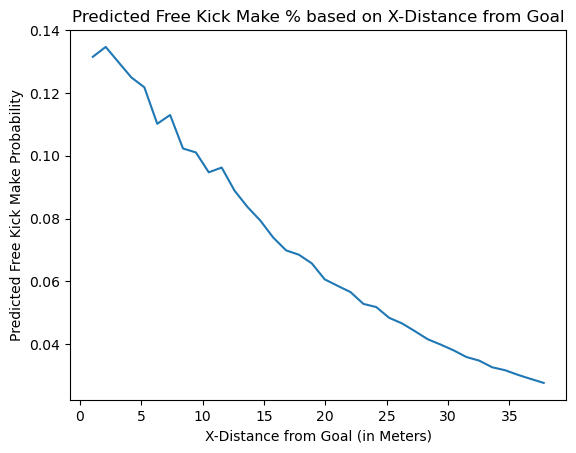

In [18]:
plt.plot(aggStatsX['distGoalX'], aggStatsX['predictedMake'])
plt.xlabel("X-Distance from Goal (in Meters)")
plt.ylabel("Predicted Free Kick Make Probability")
plt.title("Predicted Free Kick Make % based on X-Distance from Goal")
plt.show()

In [20]:
aggStatsY = pd.DataFrame(full_stats.groupby('distGoalY').agg({'predictedMake' : 'mean'})).reset_index()

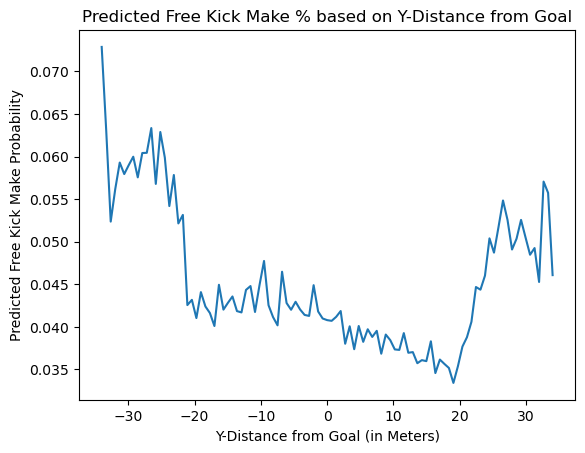

In [22]:
plt.plot(aggStatsY['distGoalY'], aggStatsY['predictedMake'])
plt.xlabel("Y-Distance from Goal (in Meters)")
plt.ylabel("Predicted Free Kick Make Probability")
plt.title("Predicted Free Kick Make % based on Y-Distance from Goal")
plt.show()

In [133]:
full_stats['FKGoalsOverExpected'] = full_stats['Is_Goal'] - full_stats['predictedMake']

In [134]:
aggByPlayer = pd.DataFrame(full_stats.groupby('wyId').agg({"FKGoalsOverExpected" : "mean",
                                                           "distGoalX" : "count"}).sort_values(by = "FKGoalsOverExpected", 
                                                                                                        ascending=False)).drop_duplicates()

In [137]:
df['Full Name'] = df['firstName'] + ' ' + df['lastName']

In [156]:
aggByPlayer = pd.merge(aggByPlayer, df[['Full Name', 'shortName', 'wyId']],
                       on= 'wyId').drop_duplicates()

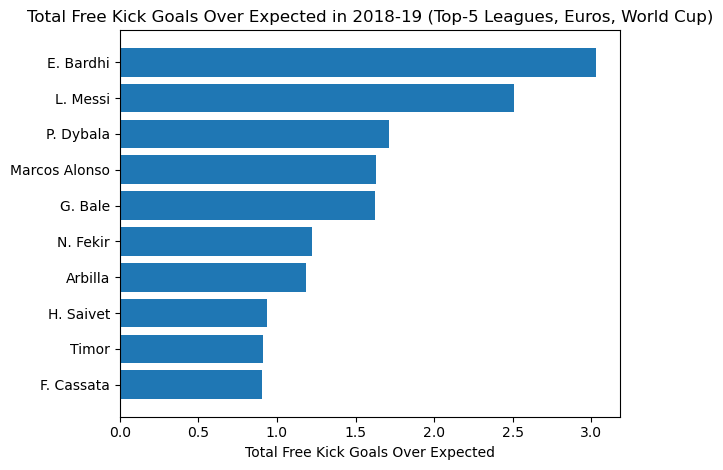

In [159]:
plt.barh(aggByPlayer.head(n = 10)['shortName'],
        aggByPlayer.head(n = 10)['TotalFKGoalsOverExpected'])
plt.xlabel("Total Free Kick Goals Over Expected")
plt.title("Total Free Kick Goals Over Expected in 2018-19 (Top-5 Leagues, Euros, World Cup)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [153]:
aggByPlayer.to_csv("FinalFKGOE.csv")

In [160]:
from IPython.display import Image, display

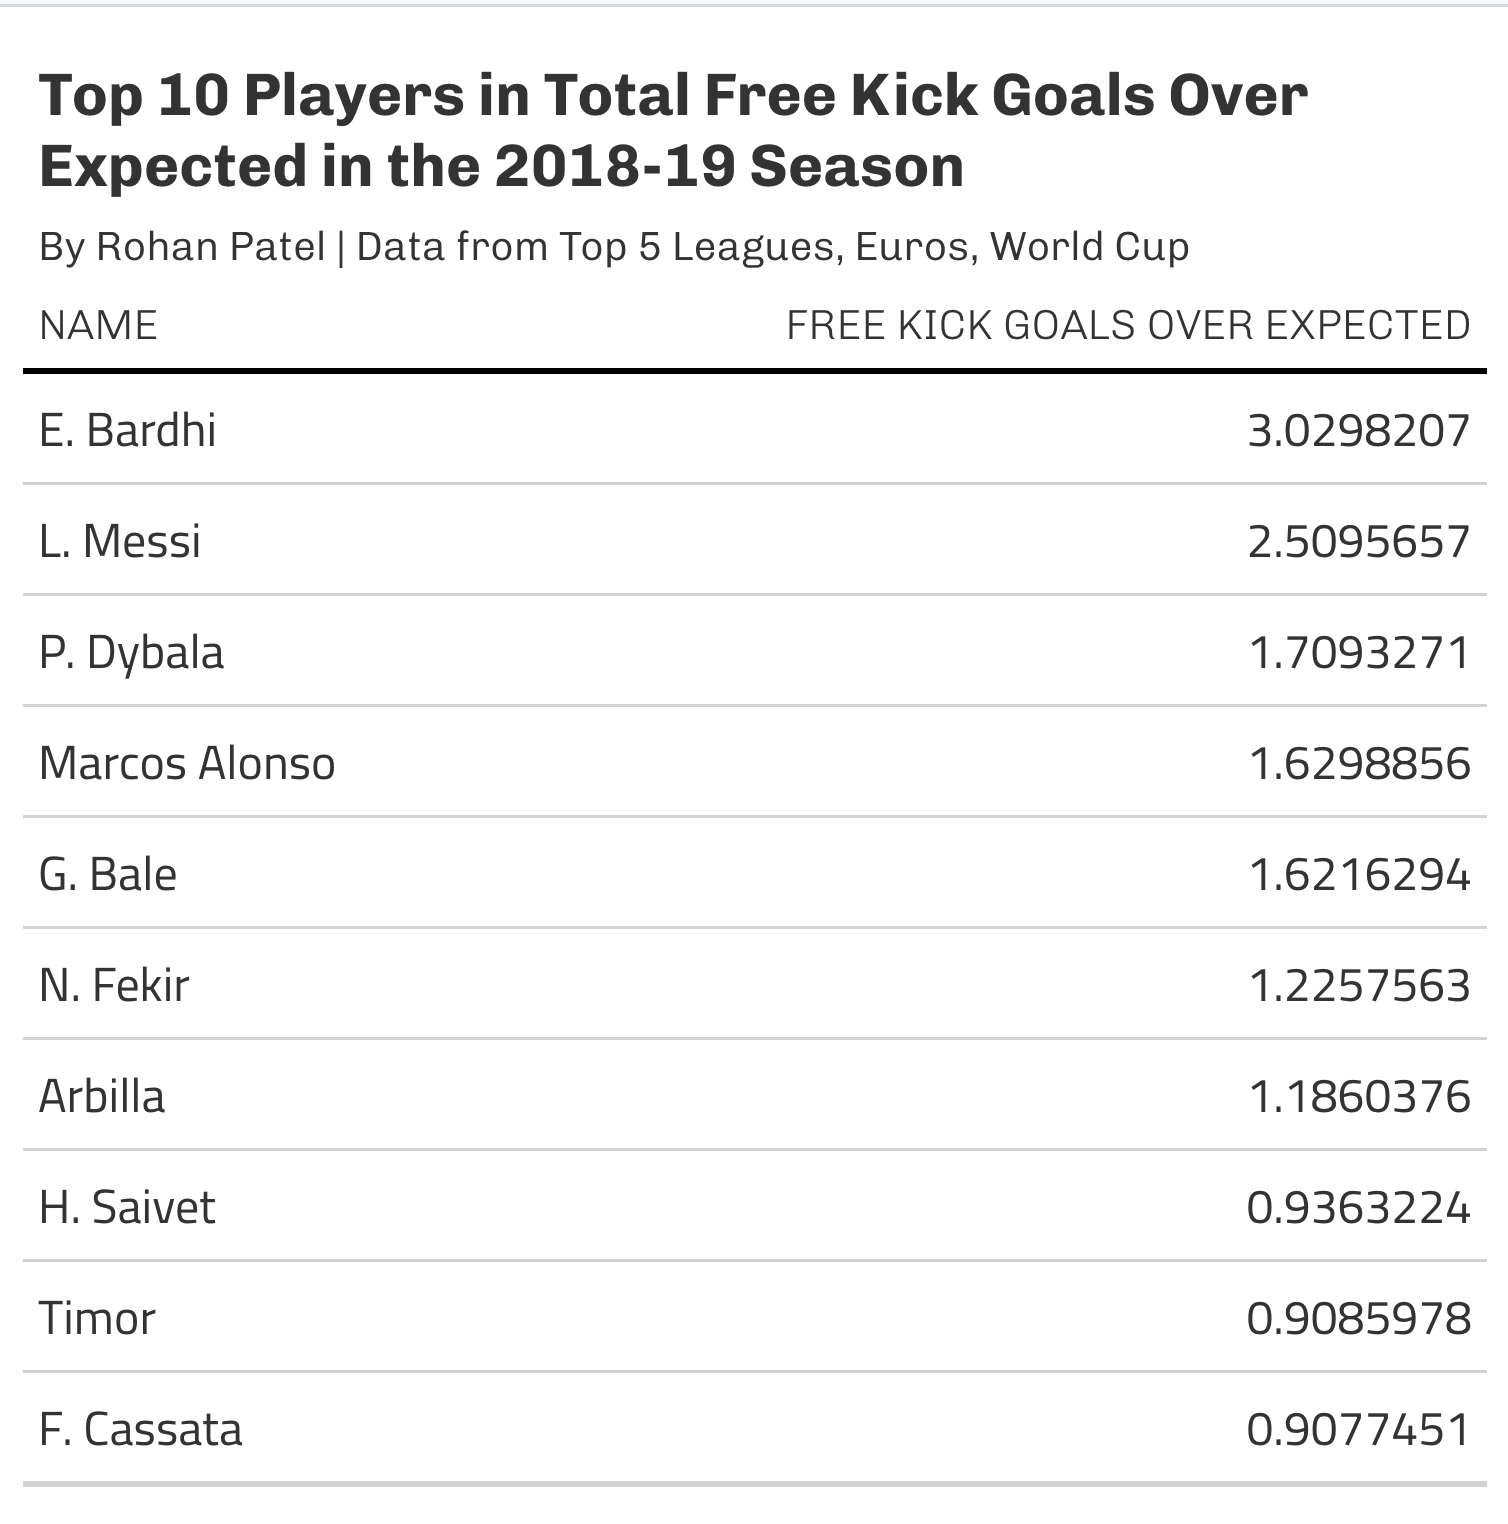

In [161]:
display(Image(filename='Table.png',
              width = 500,
              height = 1000))